# Examples to use the Functions

## Import other notebooks as python modules

First we need to import the functions provided by the other notebook: **Photron Analysis Functions**. To do this, we need to run this first cell:

In [8]:
#Modules to be load before Importing notebook
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

Then we need to run the cells under the **Function for notebook importer** subtitle, where the importer classes are defined and the notebook is imported as a module. 

### Function for Notebook importer

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

Finally we use this function to import our notebook as a python module:

In [12]:
import Photron_Analysis_Functions as Phot

# Examples

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

## Unpacking flowmeter data

The flowmeter data is contained in .lvm files that can be extracted by using the function:

```python
lvm_unpack()
```

In [17]:
t, flow = Phot.lvm_unpack('../flowmeter/FlowMeterData_200.lvm')

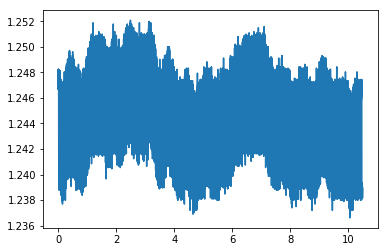

In [18]:
plt.plot(t,flow)

## Jet edges files

The Sobel right and left files contains the edges of the jets in pixels we can extract them and plot them. The rows contains the time series and columns contians de space.

In [21]:
txt_name_l = 'sobel_left209.txt'
data_l = np.loadtxt(txt_name_l,unpack=True)
no_images = data_l.shape[0]

txt_name_r = 'sobel_right209.txt'
data_r = np.loadtxt(txt_name_r,unpack=True)


data_l.shape #8000 frames per 924 pixels

(8000, 924)

Text(0.5,1,'Jet Edges')

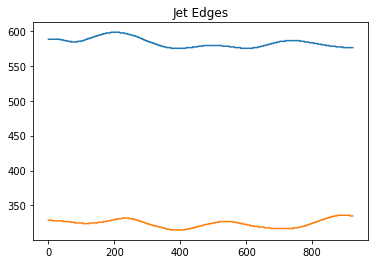

In [23]:
plt.plot(data_l[1,:])
plt.plot(data_r[1,:])
plt.title('Jet Edges')

It might be necessary to smooth the data, we can do through a loop with the function:
```python
smooth()
```

In [24]:
left = np.zeros((no_images,data_l.shape[1]))
right = np.zeros((no_images,data_r.shape[1]))
for i in range(no_images):
        wave_l = Phot.smooth(data_l[i,:],window_len=100,window='hanning')
        left[i,:] = wave_l
        wave_r = Phot.smooth(data_r[i,:],window_len=100,window='hanning')
        right[i,:] = wave_r

Text(0.5,1,'Smoothed Edges')

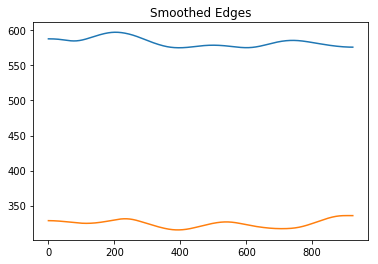

In [25]:
plt.plot(left[1,:])
plt.plot(right[1,:])
plt.title('Smoothed Edges')

We can make the data contain zero-crossings by using the function:
```python
substract_zero_crossing
```

Text(0.5,1,'Zero crossing')

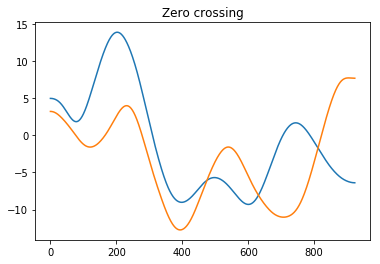

In [28]:
left = Phot.substract_zero_crossing(left)
right = Phot.substract_zero_crossing(right)

plt.plot(left[1,:])
plt.plot(right[1,:])
plt.title('Zero crossing')

We also need a scale px to mm in ths case of this files the scaling is 49.07px to 1mm

Text(0.5,1,'Milimeters')

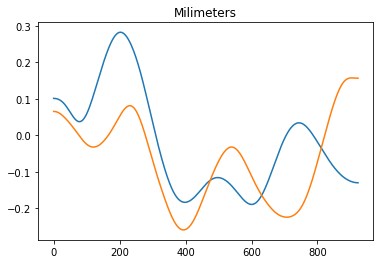

In [29]:
scale =49.07

left = left/scale
right = right/scale

plt.plot(left[1,:])
plt.plot(right[1,:])
plt.title('Milimeters')